In [1]:
# Scraping and loading 
from __future__ import print_function
import csv
import lxml.html

# Dataframe handling
import pandas as pd
import numpy as np

# Regression and other stats modules
from patsy import dmatrices
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from sklearn import 

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels import graphics

# Random Seed Generator to make this 'world' still.
np.random.seed(1024)

In [ ]:
url1 = 'http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=matches;'
url2 = 'page='
url3 = 'size=200;template=results;type=batting;view=season'
url5 = ['http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=matches;size=200;template=results;type=batting;view=season']
for i in range(1,64):
    url4 = url1 + url2 + str(i) + ';' + url3
    url5.append(url4)

In [ ]:
out = csv.writer(open('ODI_batting.csv','wb',))
out.writerow(('Player','Matches','Inns','NO','Runs','HS','Ave','BF','SR','Centuries','Fifties', 'Ducks', 'Season'))

for page in url5:
    Player = []
    Matches = []
    Inns = []
    NO = []
    Runs = []
    HS = []
    Ave=[]
    BF=[]
    SR = []
    Centuries = []
    Fifties = []
    Ducks = []
    Season = []
    
    content = lxml.html.parse(page)
    
    Player.extend(content.xpath('//tr[@class="data1"]/td[1]/a/text()'))
    Matches.extend(content.xpath('//tr[@class="data1"]/td[2]/b/text()'))
    Inns.extend(content.xpath('//tr[@class="data1"]/td[3]/text()'))
    NO.extend(content.xpath('//tr[@class="data1"]/td[4]/text()'))
    Runs.extend(content.xpath('//tr[@class="data1"]/td[5]/text()'))
    HS.extend(content.xpath('//tr[@class="data1"]/td[6]/text()'))
    Ave.extend(content.xpath('//tr[@class="data1"]/td[7]/text()'))
    BF.extend(content.xpath('//tr[@class="data1"]/td[8]/text()'))
    SR.extend(content.xpath('//tr[@class="data1"]/td[9]/text()'))
    Centuries.extend(content.xpath('//tr[@class="data1"]/td[10]/text()'))
    Fifties.extend(content.xpath('//tr[@class="data1"]/td[11]/text()'))
    Ducks.extend(content.xpath('//tr[@class="data1"]/td[12]/text()'))
    Season.extend(content.xpath('//tr[@class="data1"]/td[13]/text()'))
    
    # This part of code may not be needed
    zipped = zip(Player, Matches, Inns, NO, Runs, HS, Ave, BF, SR, Centuries, Fifties, Ducks, Season)
    for row in zipped:
        out.writerow(row)
        zipped = None

In [ ]:
batting_df = pd.read_csv(r"ODI_batting.csv")
batting_df.head()

In [ ]:
# Cleaning up records with - or * chars or nan.
import math
batting_df['Innings'] = batting_df.Inns.str.replace('-', '0').astype(float)
#batting_df['Innings'] = batting_df.Inns.str.replace('nan', '0')
#Removing rows with <2 innings.
batting_with_inns = batting_df[(batting_df.Innings) > 1 ]

In [ ]:
batting_with_inns['Hundreds'] = batting_with_inns.Centuries.str.replace('nan', '0').astype(float)
batting_with_inns['TotalRuns'] = batting_with_inns.Runs.str.replace('nan', '0').astype(float)
batting_with_inns['NotOuts'] = batting_with_inns.NO.str.replace('-', '0').astype(float)
batting_with_inns['BallsFaced'] = batting_with_inns.BF.str.replace('nan', '0').astype(float)
batting_with_inns['DuckedOut'] = batting_with_inns.Ducks.str.replace('nan', '0').astype(float)
batting_with_inns['FiftyRuns'] = batting_with_inns.Fifties.str.replace('nan', '0').astype(float)
batting_with_inns['BattingAvg'] = batting_with_inns.Ave.str.replace('-', '0').astype(float)
batting_with_inns['HighestScore'] = batting_with_inns.HS.str.replace('*', '').astype(float)
batting_with_inns['StrikeRate'] = batting_with_inns.SR.replace('-', 0).astype(float)

In [56]:
batting_with_inns.drop(batting_with_inns.columns[[0,2,3,4,5,6,7,8,9,10,11]], axis=1, inplace=True)

# Write to a csv file.
batting_with_inns.to_csv(r"ODI_batting_cleaned.csv")


NameError: name 'batting_with_inns' is not defined

In [2]:
# Read in to a Pandas dataframe
pl_bat_df = pd.read_csv(r"ODI_batting_cleaned.csv")

In [3]:
pl_bat_df.head()

,Unnamed: 0,Matches,Season,Innings,Hundreds,TotalRuns,NotOuts,BallsFaced,DuckedOut,FiftyRuns,BattingAvg,HighestScore,StrikeRate
0,0,32,2006/07,23,2,670,7,833,1,1,41.87,109,80.43
1,1,31,2002/03,31,5,1134,4,1505,2,4,42.00,124,75.34
2,2,31,2002/03,30,2,912,6,1246,1,3,38.00,103,73.19
3,3,31,2005/06,30,2,1254,1,1604,1,10,43.24,138,78.17
4,4,30,1996/97,27,0,554,7,730,1,2,27.70,61,75.89


In [4]:
pl_bat_df['SeasonYear'] = pl_bat_df['Season'].str.split('/').str[0]

# Run this only once
pl_bat_df.drop(pl_bat_df.columns[[0,2]], axis=1, inplace=True)

In [5]:
pl_bat_df['SeasonYear'] = pl_bat_df.SeasonYear.astype(float)

In [6]:
pl_bat_df.describe()

,Matches,Innings,Hundreds,TotalRuns,NotOuts,BallsFaced,DuckedOut,FiftyRuns,BattingAvg,HighestScore,StrikeRate,SeasonYear
count,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000
mean,8.207887,6.733313,0.164883,156.832365,1.231020,212.354632,0.552736,0.842046,24.090651,46.847142,69.451613,2000.066239
std,6.019518,5.334959,0.536976,197.502988,1.500145,253.035294,0.799508,1.456922,19.566155,37.041573,25.540621,10.364401
min,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1972.000000
25%,3.000000,3.000000,0.000000,27.000000,0.000000,44.000000,0.000000,0.000000,10.000000,16.000000,54.680000,1993.000000
50%,6.000000,5.000000,0.000000,79.000000,1.000000,115.000000,0.000000,0.000000,20.500000,38.000000,69.000000,2002.000000
75%,11.000000,9.000000,0.000000,206.000000,2.000000,277.000000,1.000000,1.000000,33.660000,71.000000,82.950000,2009.000000
max,32.000000,31.000000,6.000000,1390.000000,12.000000,1604.000000,6.000000,10.000000,304.000000,264.000000,300.000000,2015.000000


In [7]:
def regress_data(df, X_var, y_var):
    '''
    Input a dataframe, X-list, and y-variable
    
    '''
    #X_tr = df[X_var]
    #y_tr = df[y_var]
    regrmodel = sm.OLS(y_var, X_var).fit()
    return regrmodel

def plot_regr_res(df, X_var, y_var, regrmodel):
    X = df[X_var]
    y = df[y_var]
    pred_y = regrmodel.predict(X)
    plt.plot(y, pred_y, 'y-')
    plt.plot(y, y)
    plt.xlabel('Actual %s' %y_var )
    plt.ylabel('Predicted %s' %y_var)
    # Plot the 95% confidence intervals
    prstd, conf_l, conf_u = wls_prediction_std(regrmodel)
    #plt.plot(np.exp(conf_l), 'ys')
    #plt.plot(np.exp(conf_u), 'ys')
    
def plot_actual_fitted(df, X_var, y_var, regrmodel):
    plt.figure();
    plt.plot(df[X_var], df[y_var], 'o', x, y_true, 'b-');
    prstd, iv_l, iv_u = wls_prediction_std(regrmodel.res);
    plt.plot(x, res.fittedvalues, 'r .');
    plt.plot(x, iv_u, 'r ');
    plt.plot(x, iv_l, 'r ');
    plt.title('blue: true,   red: OLS');

def diagnostics_plots1(df, regrmodel):
    #fig, ax = plt.subplots(figsize=(12, 8))
    plt.hist(regrmodel.resid)
    graphics.gofplots.qqplot(regrmodel.resid, line='y')
    plot_leverage_resid2(regrmodel)
    
def diagnostics_X_plots(df, X_var, regrmodel):
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(regrmodel, X_var, fig=fig)
    #fig, ax = plt.subplots(figsize=(8,6))
    #fig = sm.graphics.influence_plot(regrmodel, ax=ax)

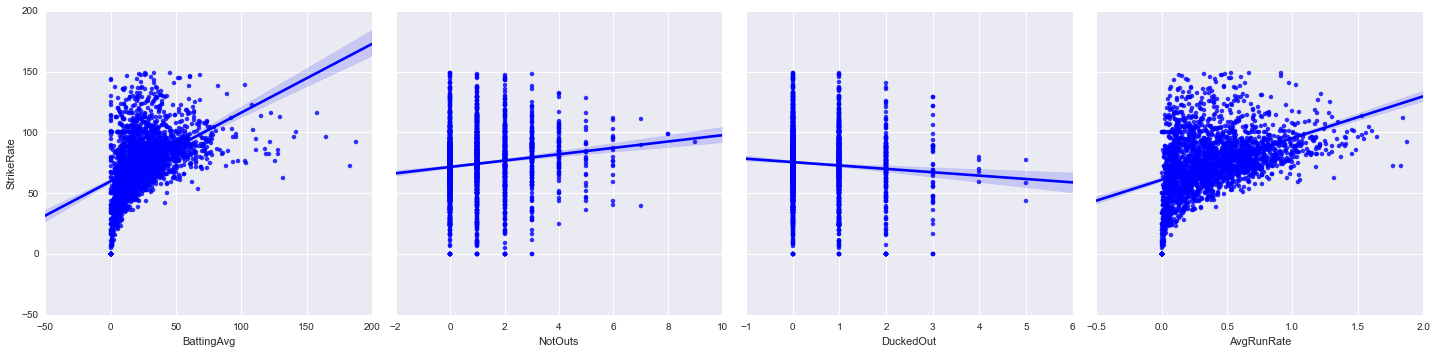

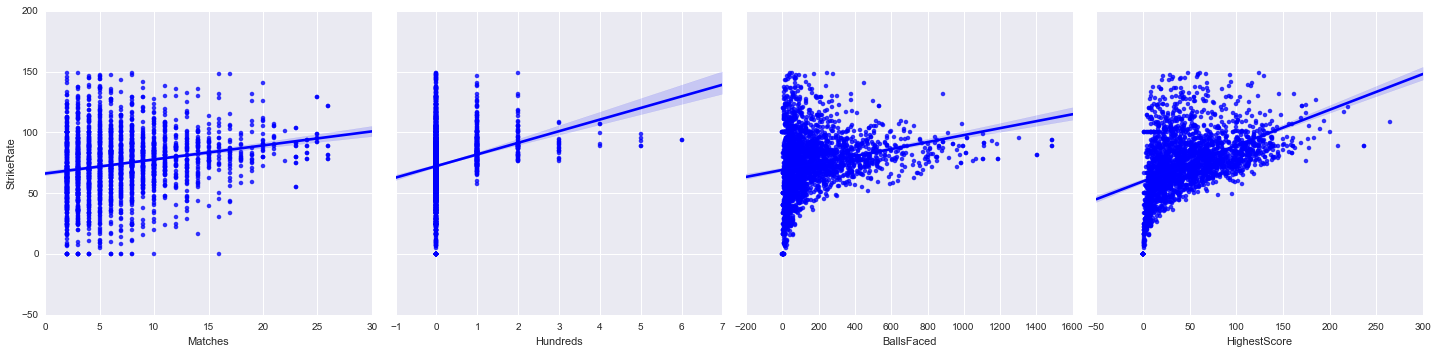

In [18]:
from scipy import stats
pl_bat_df['AvgRunRate'] = pl_bat_df.TotalRuns / pl_bat_df.Matches / 50
filtered_df = pl_bat_df[(pl_bat_df.StrikeRate < 150)]
filtered_df = filtered_df[(filtered_df.SeasonYear > 2008)]
#filtered_df['logStrikeRate'] = filtered_df[np.log(filtered_df.StrikeRate)]
filtered_df['AvgRunRate'] = pl_bat_df.TotalRuns / pl_bat_df.Matches / 50
g = sns.PairGrid(filtered_df, y_vars=["StrikeRate"], x_vars=["BattingAvg", "NotOuts", "DuckedOut", 'AvgRunRate'], size=5)
g.map(sns.regplot, color="b")

g = sns.PairGrid(filtered_df, y_vars=["StrikeRate"], x_vars=["Matches", "Hundreds", "BallsFaced", "HighestScore"], size=5)
g.map(sns.regplot, color="b")

In [19]:
len(filtered_df)

2477

In [77]:
filtered_df = filtered_df.iloc[np.random.permutation(len(filtered_df))]
y_all, X_all = dmatrices('StrikeRate ~ BattingAvg*AvgRunRate+HighestScore*Matches'\
                 ,data=filtered_df, return_type='dataframe')
#corR = np.corrcoef(X_all, rowvar=1)

In [82]:
from sklearn import datasets, linear_model
from sklearn import cross_validation

filtered_df = filtered_df.iloc[np.random.permutation(len(filtered_df))]
linear_reg_model = linear_model.LinearRegression()
rsq_scores = cross_validation.cross_val_score(linear_reg_model, X_all, y_all, n_jobs=3,cv=5)
rsq_scores


[array([ 0.28607708,  0.23804915,  0.34539185,  0.28428975,  0.34039473])]

In [23]:
linear_reg_model.fit(X_all, y_all)

NameError: name 'linear_reg_model' is not defined

In [21]:
# The coefficients
print('Coefficients: \n', linear_reg_model.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((linear_reg_model.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_reg_model.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, linear_reg_model.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

NameError: name 'linear_reg_model' is not defined

In [79]:
statsModel_lr_model1 = regress_data(filtered_df, X_all, y_all)

In [80]:
statsModel_lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             StrikeRate   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     179.6
Date:                Fri, 17 Jul 2015   Prob (F-statistic):          4.46e-190
Time:                        06:21:26   Log-Likelihood:                -11099.
No. Observations:                2477   AIC:                         2.221e+04
Df Residuals:                    2470   BIC:                         2.225e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                45.2729      1.313     34.469      0.000        42.697    47.848
BattingAvg                0.9126      0.057     16.131      0.000         0.802     1.024
AvgRunRate               11.3985      4.216      2.704      0.007         3.132    19.665
BattingAvg:AvgRunRate    -0.6098      0.045    -13.509      0.000        -0.698    -0.521
HighestScore              0.1770      0.035      5.056      0.000         0.108     0.246
Matches                   0.8413      0.169      4.985      0.000         0.510     1.172
HighestScore:Matches     -0.0091      0.002     -4.539      0.000        -0.013    -0.005
==============================================================================
Omnibus:                      279.439   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              417.744
Skew:                           0.827   Prob(JB):                     1.94e-91
Kurtosis:                       4.146   Cond. No.                     7.19e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [233]:
filtered_df = filtered_df.iloc[np.random.permutation(len(filtered_df))]
y_all, X_stripped = dmatrices('StrikeRate ~ Matches*AvgRunRate+'\
                 ,data=filtered_df, return_type='dataframe')

In [234]:
statsModel_lr_model2 = regress_data(filtered_df, X_stripped, y_all)

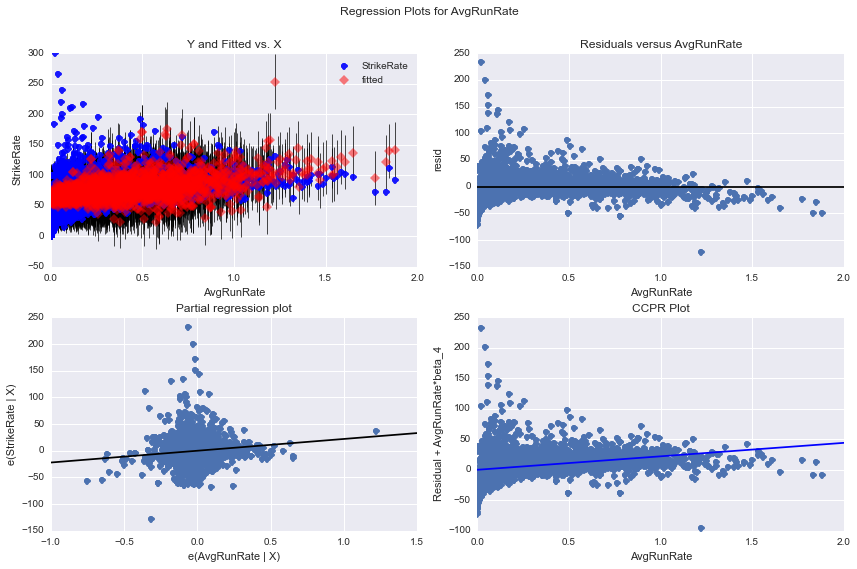

In [258]:
diagnostics_X_plots(filtered_df, 'AvgRunRate', statsModel_lr_model1)

In [59]:
from mpl_toolkits.mplot3d import Axes3D

def linear_model3D(df_adv):
    X = df_adv[['AvgRunRate', 'BattingAvg']]
    y = df_adv['StrikeRate']

    ## fit a OLS model with intercept on TV and Radio
    X = sm.add_constant(X)
    est = sm.OLS(y, X).fit()

    ## Create the 3d plot -- skip reading this
    # TV/Radio grid for 3d plot
    xx1, xx2 = np.meshgrid(np.linspace(X.AvgRunRate.min(), X.AvgRunRate.max(), 100), 
                           np.linspace(X.BattingAvg.min(), X.BattingAvg.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

    # create matplotlib 3d axes
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig, azim=-115, elev=15)

    # plot hyperplane
    surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

    # plot data points - points over the HP are white, points below are black
    resid = y - est.predict(X)
    ax.scatter(X[resid >= 0].AvgRunRate, X[resid >= 0].BattingAvg, y[resid >= 0], color='black', alpha=1.0, facecolor='white')
    ax.scatter(X[resid < 0].AvgRunRate, X[resid < 0].BattingAvg, y[resid < 0], color='black', alpha=1.0)

    # set axis labels
    ax.set_xlabel('AvgRunRate')
    ax.set_ylabel('BattingAvg')
    ax.set_zlabel('StrikeRate')

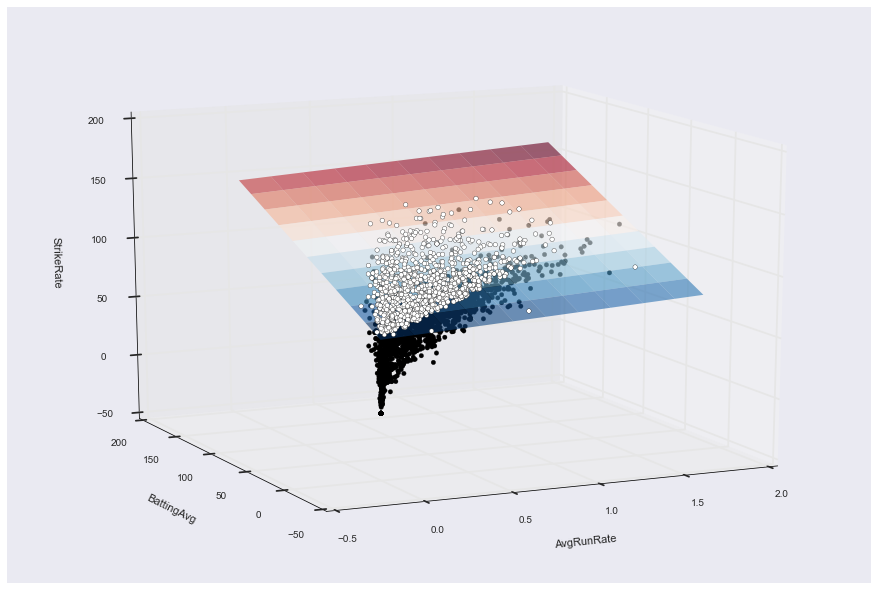

In [60]:
linear_model3D(filtered_df)

In [164]:
#from sklearn.cross_val_predict

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validated:
predicted = sklearn.cross_val_predict(linear_reg_model, X_all, y_all, cv=10)

fig,ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

NameError: name 'sklearn' is not defined

In [67]:
from sklearn.cross_validation import cross_val_predict

ImportError: cannot import name cross_val_predict

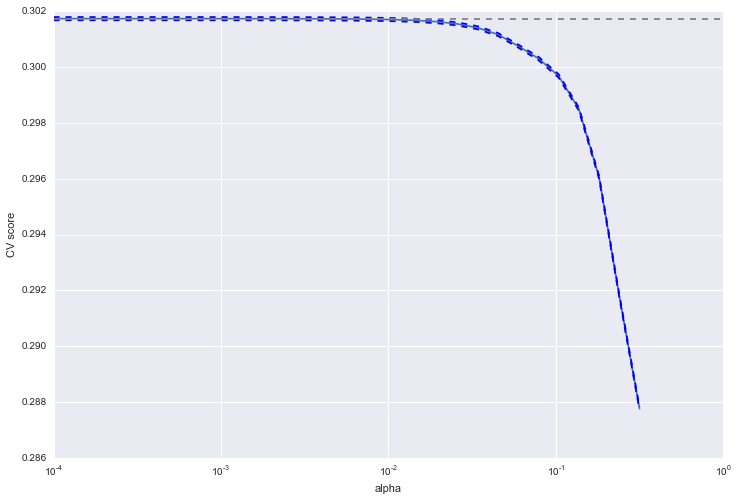

In [61]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation, datasets, linear_model

lasso = linear_model.Lasso()
alphas = np.logspace(-4, -.5, 30)

scores = list()
scores_std = list()

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_validation.cross_val_score(lasso, X_all, y_all, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.figure(figsize=(12, 8))
plt.semilogx(alphas, scores)
# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, np.array(scores) + np.array(scores_std) / np.sqrt(len(X_all)),
             'b--')
plt.semilogx(alphas, np.array(scores) - np.array(scores_std) / np.sqrt(len(X_all)),
             'b--')
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')

plt.show()

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_all,y_all, train_size=0.70, random_state=2)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

#print "mean squared error:", metrics.mean_squared_error(model.predict(x_train), y_train)

In [100]:
deviation_from_pred = pd.DataFrame(y_pred,y_test)
model.score(x_test, y_test)

0.3062578319766105

In [101]:
model.coef_

array([[  0.00000000e+00,   8.22175197e-01,   1.19697243e+01,
         -5.74772778e-01,   2.12820966e-01,   9.90339714e-01,
         -1.14345316e-02]])

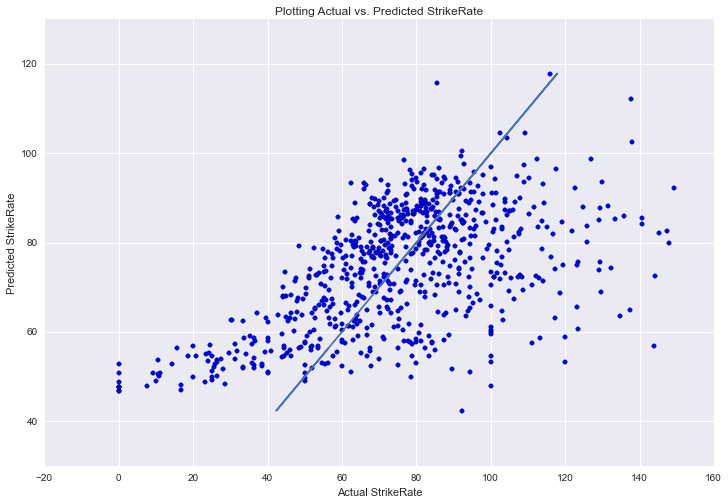

In [108]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred)
plt.title("Plotting Actual vs. Predicted StrikeRate")
plt.xlabel('Actual StrikeRate')
plt.ylabel('Predicted StrikeRate')
plt.plot(y_pred, y_pred)

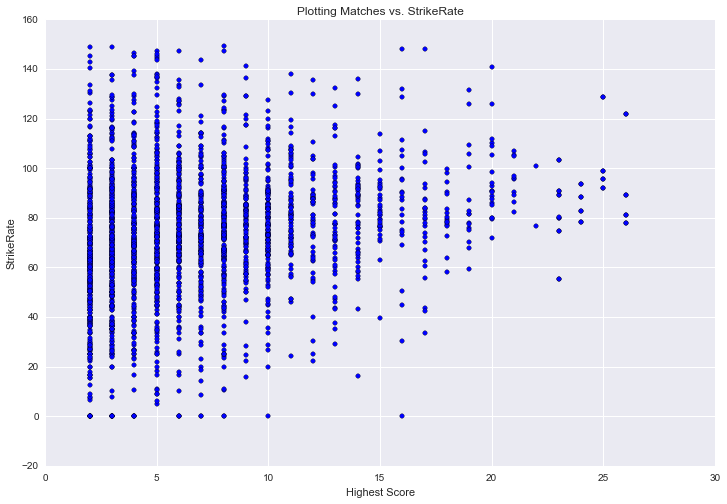

In [64]:
plt.figure(figsize=(12, 8))
plt.scatter(filtered_df.Matches, filtered_df.StrikeRate)
plt.title("Plotting Matches vs. StrikeRate")
plt.xlabel('Highest Score')
plt.ylabel('StrikeRate')